<a href="https://colab.research.google.com/github/LucasSLDantas/Face_classificator/blob/main/image_recognition_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install mtcnn facenet-pytorch tensorflow scikit-learn opencv-python matplotlib

In [15]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [16]:
def load_images_from_zip(zip_path):
    images, labels = [], []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for filename in z.namelist():
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            if filename.endswith('/'):
                continue
            parts = filename.split('/')
            if len(parts) < 2:
                continue
            label = parts[-2]
            data = z.read(filename)
            nparr = np.frombuffer(data, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            if img is None:
                continue
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            labels.append(label)
    return images, labels  # <-- retorna listas, não np.array

# Uso:
zip_path = '/content/dataset.zip'
images, labels = load_images_from_zip(zip_path)
print(f"Pré-carregadas {len(images)} imagens de {len(set(labels))} classes.")

Pré-carregadas 337 imagens de 4 classes.


In [17]:
detector = MTCNN()
faces, face_labels = [], []
for img, label in zip(images, labels):
    res = detector.detect_faces(img)
    if not res:
        continue
    x, y, w, h = res[0]['box']
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))
    faces.append(face)
    face_labels.append(label)

faces = np.array(faces)             # agora todas têm (160,160,3)
face_labels = np.array(face_labels)
print(f"Detectei e alinhei {len(faces)} faces.")

Detectei e alinhei 337 faces.


In [18]:
import torch
import numpy as np
from facenet_pytorch import InceptionResnetV1

# Carrega o ResNet pré-treinado em VGGFace2 (embeddings de 512-d)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

def get_embedding(resnet_model, face_pixels):
    """
    face_pixels: np.array (160×160×3), dtype=uint8 ou float32 (0–255)
    retorna embedding numpy float32 shape (512,)
    """
    # converte para tensor C×H×W e float
    face_tensor = torch.from_numpy(face_pixels).permute(2,0,1).float()
    # normaliza para [-1,1]
    face_tensor = (face_tensor - 127.5) / 128.0
    # batch
    face_tensor = face_tensor.unsqueeze(0)
    with torch.no_grad():
        emb = resnet_model(face_tensor)      # shape (1,512)
    return emb[0].cpu().numpy()

# Gera todos os embeddings a partir de `faces` (shape N×160×160×3)
embeddings = np.stack([get_embedding(resnet, f) for f in faces])
print('Embeddings shape:', embeddings.shape)  # deve dar (N, 512)

Embeddings shape: (337, 512)


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 6.1 — Transformar rótulos em inteiros
le = LabelEncoder()
y = le.fit_transform(face_labels)

# 6.2 — Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 6.3 — Treinar SVM com RBF
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)

# 6.4 — Avaliar
y_pred = clf.predict(X_test)
print('Acurácia de teste:', accuracy_score(y_test, y_pred))

Acurácia de teste: 1.0


In [20]:
import matplotlib.pyplot as plt

def recognize_face(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = detector.detect_faces(img_rgb)
    if not res:
        print('Nenhuma face detectada.')
        return

    # extrai e alinha
    x, y, w, h = res[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))

    # embedding + predição
    emb = get_embedding(resnet, face)
    probs = clf.predict_proba([emb])[0]
    idx = np.argmax(probs)
    name = le.inverse_transform([idx])[0]
    conf = probs[idx]

    # desenha
    cv2.rectangle(img_bgr, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(img_bgr,
                f'{name} ({conf:.2f})',
                (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')

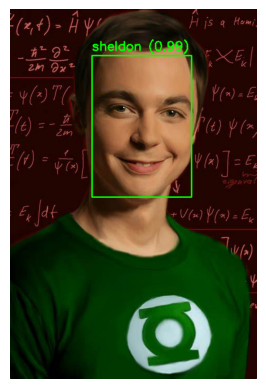

In [23]:
# Exemplo de uso:
recognize_face('/content/teste_image_classificator_3.jpg')